## Imports

In [1]:
import torch
import shutil
import random
import glob

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image

from torch import optim
from torch import nn

from matplotlib.patches import Rectangle

import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision import models

import torchvision


import matplotlib.pyplot as plt

## Data sorting

In [2]:
######## CARS #########
f1  = open("class_string.txt", "r").read().split("\n")
f2  = open("fname_string.txt", "r").read().split("\n")
f3 = open("bbox.txt", "r").read().split("\n")
totbbox = []
for ind, line in enumerate(f3):
    f1[ind] = int(f1[ind])
    bbox = line.split("\t") # x1,y1,x2,y2
    bbox[0] = float(bbox[0])
    bbox[1] = float(bbox[1])
    bbox[2] = float(bbox[2])
    bbox[3] = float(bbox[3])
    totbbox.append(bbox)
fin_list = []
for i in range(len(f2)):
    fin_list.append([f2[i],f1[i],totbbox[i][0],totbbox[i][1],totbbox[i][2],totbbox[i][3]])
df = pd.DataFrame(fin_list, columns=['image_id','labels', 'x0','y0','x1','y1'])


In [3]:
######## License plates ##########
f4 = open("lp_bb.txt", "r").read().split("\n")
totbbox = []
for line in f4:
    if(line==""):
        break
    bbox = line.split("\t") # x1,y1,x2,y2
    bbox[0] = float(bbox[0])
    bbox[1] = float(bbox[1])
    bbox[2] = float(bbox[2])
    bbox[3] = float(bbox[3])
    totbbox.append(bbox)
fin_list = []
for i in range(len(f4)-1):
    fin_list.append(["Cars{}.png".format(i),1,totbbox[i][0],totbbox[i][1],totbbox[i][2],totbbox[i][3]])
df_LP = pd.DataFrame(fin_list, columns=['image_id','labels', 'x0','y0','x1','y1'])

In [4]:
######## Full_set ##########
f1  = open("class_string.txt", "r").read().split("\n")
f2  = open("fname_string.txt", "r").read().split("\n")
f3 = open("bbox.txt", "r").read().split("\n")
totbbox = []
for ind, line in enumerate(f3):
    f1[ind] = int(f1[ind])
    bbox = line.split("\t") # x1,y1,x2,y2
    bbox[0] = float(bbox[0])
    bbox[1] = float(bbox[1])
    bbox[2] = float(bbox[2])
    bbox[3] = float(bbox[3])
    totbbox.append(bbox)
fin_list = []
for i in range(len(f2)):
    fin_list.append([f2[i],f1[i],totbbox[i][0],totbbox[i][1],totbbox[i][2],totbbox[i][3]])
df = pd.DataFrame(fin_list, columns=['image_id','labels', 'x0','y0','x1','y1'])

f4 = open("lp_bb.txt", "r").read().split("\n")
totbbox = []
for line in f4:
    if(line==""):
        break
    bbox = line.split("\t") # x1,y1,x2,y2
    bbox[0] = float(bbox[0])
    bbox[1] = float(bbox[1])
    bbox[2] = float(bbox[2])
    bbox[3] = float(bbox[3])
    totbbox.append(bbox)

for i in range(len(f4)-1):
    fin_list.append(["Cars{}.png".format(i),197,totbbox[i][0],totbbox[i][1],totbbox[i][2],totbbox[i][3]])
df_tot = pd.DataFrame(fin_list, columns=['image_id','labels', 'x0','y0','x1','y1'])

print(df_tot)

         image_id  labels     x0     y0      x1      y1
0       00001.jpg      14   39.0  116.0   569.0   375.0
1       00002.jpg       3   36.0  116.0   868.0   587.0
2       00003.jpg      91   85.0  109.0   601.0   381.0
3       00004.jpg     134  621.0  393.0  1484.0  1096.0
4       00005.jpg     106   14.0   36.0   133.0    99.0
...           ...     ...    ...    ...     ...     ...
8572  Cars428.png     197  142.0  128.0   258.0   157.0
8573  Cars429.png     197   86.0  166.0   208.0   195.0
8574  Cars430.png     197   38.0  159.0   116.0   197.0
8575  Cars431.png     197   55.0   82.0   343.0   147.0
8576  Cars432.png     197   95.0  258.0   196.0   284.0

[8577 rows x 6 columns]


## Data Handler


In [5]:
class CarDataset(Dataset):
    def __init__(self, df, image_dir, transforms= None):
        super().__init__()
        
        self.df = df
        self.image_ids = self.df['image_id']
        self.image_dir = image_dir
        self.labels = self.df['labels']
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df["image_id"]==image_id]
        
        img = Image.open(self.image_dir/image_id).convert("RGB")
        img = transforms.ToTensor()(img)
        
        boxes = records[["x0","y0", "x1", "y1"]].values
        boxes = torch.tensor(boxes)
        boxes = boxes.type(torch.FloatTensor)
        labels = records["labels"].values
        labels = torch.tensor(labels)
        labels = labels.type(torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return img, target
                            
                                  
                                  
    def __len__(self):
        return self.image_ids.shape[0]
    
def collate_fn(batch):
    return tuple(zip(*batch))  
        
dataset = CarDataset(df, Path.cwd() / "cars_train") #"train_all"
dataset_LP = CarDataset(df_LP,Path.cwd() / "LPtrain/images")        
dataloaded = DataLoader(dataset, batch_size=2, collate_fn = collate_fn)  
dataloaded_LP = DataLoader(dataset_LP, batch_size=2, collate_fn = collate_fn)

dataset_tot = CarDataset(df_tot, Path.cwd() / "tot_train")
dataloaded_tot = DataLoader(dataset_tot, batch_size=1, collate_fn = collate_fn, shuffle = True)

## Create model

In [6]:
###### CAR ########
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = models.detection.fasterrcnn_resnet50_fpn(pretrained = True, pretrained_backbone = True)#, num_classes = 197)

classes = 197
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

load_old_model = True

if(load_old_model):
    model.load_state_dict(torch.load(Path.cwd() / "one_epoch"))



In [27]:
###### License plate ########
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model_LP = models.detection.fasterrcnn_resnet50_fpn(pretrained = True, pretrained_backbone = True)#, num_classes = 197)

classes = 2
in_features = model_LP.roi_heads.box_predictor.cls_score.in_features
model_LP.roi_heads.box_predictor = FastRCNNPredictor(in_features,classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_LP.to(device)

load_old_model_LP = False

if(load_old_model_LP):
    model_LP.load_state_dict(torch.load(Path.cwd() / ""))


In [6]:
###### Tot set ########
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model_tot = models.detection.fasterrcnn_resnet50_fpn(pretrained = True, pretrained_backbone = True)#, num_classes = 197)

classes = 198
in_features = model_tot.roi_heads.box_predictor.cls_score.in_features
model_tot.roi_heads.box_predictor = FastRCNNPredictor(in_features,classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_tot.to(device)

load_old_model_tot = True

if(load_old_model_tot):
    model_tot.load_state_dict(torch.load(Path.cwd() / "Model_tot_first_functional"))


## Training


In [28]:
###### CAR ######
model.train()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 3
for epoch in range(num_epochs):
    for i,(b_x, b_y) in enumerate(dataloaded):
        b_x = [item.to(device) for item in b_x]
        b_y = [{key: values.to(device) for key, values in target.items()} for target in b_y]
        loss_dict=model(b_x,b_y)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if(i%100 == 0):
            print(losses)
    lr_scheduler.step()
    print(epoch)

save_model = False
if(save_model):
    torch.save(model.state_dict(), "Model_2")
    

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Deep-machine-learning-BB\\cars_train\\00001.jpg'

In [10]:
###### License plate ########

model_LP.train()

params = [p for p in model_LP.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 1
for epoch in range(num_epochs):
    for i,(b_x, b_y) in enumerate(dataloaded_LP):
        b_x = [item.to(device) for item in b_x]
        b_y = [{key: values.to(device) for key, values in target.items()} for target in b_y]
        loss_dict=model_LP(b_x,b_y)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if(i%10 == 0):
            print(losses)
    lr_scheduler.step()
    print(epoch)

save_model_LP = False
if(save_model_LP):
    torch.save(model_LP.state_dict(), "Model_1")

tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3470, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2228, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2170, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2984, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2880, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2169, device='cuda:0', grad_fn=<AddBack

tensor(0.0934, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2189, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2699, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1109, device='cuda:0', grad_fn=<AddBack

tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1256, device='cuda:0', grad_fn=<AddBack

tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2653, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3576, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2404, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2106, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1175, device='cuda:0', grad_fn=<AddBack

tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2284, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2290, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1828, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2860, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1488, device='cuda:0', grad_fn=<AddBack

tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2381, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1548, device='cuda:0', grad_fn=<AddBack

In [9]:
###### Tot set ######

model_tot.train()

params = [p for p in model_tot.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 20
for epoch in range(num_epochs):
    for i,(b_x, b_y) in enumerate(dataloaded_tot):
        b_x = [item.to(device) for item in b_x]
        b_y = [{key: values.to(device) for key, values in target.items()} for target in b_y]
        loss_dict=model_tot(b_x,b_y)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if(i%100 == 0):
            print(losses)
    lr_scheduler.step()
    print(epoch)
    torch.save(model_tot.state_dict(), "models/Model_tot_epoch_{}".format(epoch))
    
save_model_tot = False
if(save_model_LP):
    torch.save(model_tot.state_dict(), "Model_tot_1")

tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3099, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1937, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1988, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1701, device='cuda:0', grad_fn=<AddBack

tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1640, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1866, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1883, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1806, device='cuda:0', grad_fn=<AddBack

tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3281, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0734, device='cuda:0', grad_fn=<AddBack

tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2396, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0396, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1661, device='cuda:0', grad_fn=<AddBack

tensor(0.0261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0956, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0818, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0306, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0915, device='cuda:0', grad_fn=<AddBa

tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2676, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0174, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0753, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0640, device='cuda:0', grad_fn=<AddBack

tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0163, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0538, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0881, device='cuda:0', grad_fn=<AddBack

tensor(0.0306, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1130, device='cuda:0', grad_fn=<AddB

tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0288, device='cuda:0', grad_fn=<AddBack

tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2640, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0567, device='cuda:0', grad_fn=<AddBack

tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0275, device='cuda:0', grad_fn=<AddBack

tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1647, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)
18
tensor(0.1394, device='cuda:0', grad_fn=<AddB

NameError: name 'save_model_LP' is not defined

In [55]:
save_model_tot = True
if(save_model_tot):
    torch.save(model_tot.state_dict(), "Model_tot_first_functional2")

## Evaluation

tensor([[  43.9610,  145.4315, 1000.8810,  615.0319],
        [  49.3719,  126.1214,  974.5491,  624.2296],
        [ 756.9016,  420.9463,  902.2873,  476.5966],
        [  51.7813,  148.2353,  989.0751,  630.6246],
        [   0.0000,  124.3970,  967.4719,  607.4976],
        [  73.1610,  111.3071,  973.3693,  632.1791],
        [ 744.3370,  410.5726,  914.4159,  506.1582]], device='cuda:0')
jajaja
Label: 170/170, score: 0.9059504866600037
Label: 197/170, score: 0.3343307375907898


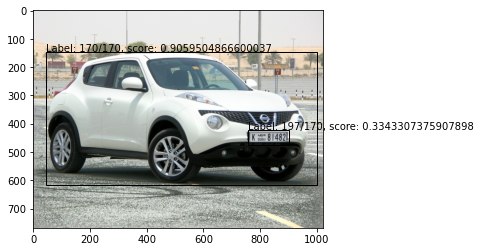

In [30]:
def eval_and_plot_image(model, df, indx,plot_image=False, plate_on_cars = False):
    model = model.eval()
    image, target = df[indx]
    images = torch.stack([image]+[image]).to(device)
    with torch.no_grad():
        out=model(images)
    if(plot_image):
        fig, ax = plt.subplots()
        ax.imshow(image.permute(1, 2, 0))
        boxes=[]
        box = out[0]['boxes'][0]
        print(out[0]['boxes'])
        width=(box[2]-box[0])
        height=(box[3]-box[1])
        
    keep = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], 0.1)
    if plate_on_cars == True:
        if 197 in out[0]['labels']:
            if len(out[0]['labels']) > 1:
                license_indx = out[0]['labels'].index(197)
                for j in len(license_indx):
                    for i in range(len(out[0]['labels'])):
                        if i in license_indx:
                            continue
                        if out[0]['boxes'][i][0] > out[0]['boxes'][license_indx][0] or out[0]['boxes'][i][2] < out[0]['boxes'][license_indx][2] or out[0]['boxes'][i][1] > out[0]['boxes'][license_indx][1] or out[0]['boxes'][i][3] < out[0]['boxes'][license_indx][3]:


    for indx in keep:
        s = "Label: {}/{}, score: {}".format(out[0]['labels'][indx],target['labels'][0],out[0]['scores'][indx])
        if(plot_image):
            width=(out[0]['boxes'][indx][2]-out[0]['boxes'][indx][0])
            height=(out[0]['boxes'][indx][3]-out[0]['boxes'][indx][1])
            ax.add_patch(Rectangle((out[0]['boxes'][indx][0],out[0]['boxes'][indx][1]),width,height,fill = False))
            ax.text(out[0]['boxes'][indx][0],out[0]['boxes'][indx][1],s)
        print(s)

eval_and_plot_image(model_tot, dataset_tot, 23, True, True)

In [15]:
#eval_and_plot_image(model, dataset, 29,True)
indices=[]
for i in range(100):        
    lab = eval_and_plot_image(model_tot, dataset_tot, i)
    indices.append(lab)
with open('50proc_tot_small.txt', 'w') as f:
    for item in indices:
        f.write("{}\n".format(item))

Label: 19/14, score: 0.44739365577697754
Label: 197/14, score: 0.05402702838182449
Label: 3/3, score: 0.6013005375862122
Label: 91/91, score: 0.836600661277771
Label: 140/134, score: 0.3912386894226074
Label: 106/106, score: 0.748272180557251
Label: 123/123, score: 0.8848198652267456
Label: 89/89, score: 0.508556604385376
Label: 197/89, score: 0.05677146464586258
Label: 96/96, score: 0.4560643136501312
Label: 197/96, score: 0.08498530089855194
Label: 167/167, score: 0.6854733228683472
Label: 58/58, score: 0.7783796191215515
Label: 197/49, score: 0.7316306829452515
Label: 49/49, score: 0.4902264475822449
Label: 186/186, score: 0.8524921536445618
Label: 193/135, score: 0.3424415588378906
Label: 197/135, score: 0.24343611299991608
Label: 115/85, score: 0.7275488376617432
Label: 193/193, score: 0.5247324109077454
Label: 172/172, score: 0.9541983008384705
Label: 14/14, score: 0.44717487692832947
Label: 82/73, score: 0.4626469016075134
Label: 192/192, score: 0.8490145802497864
Label: 179/57,

tensor([[ 40.7122, 164.8465, 601.4568, 390.0497],
        [ 52.6070, 171.3932, 582.3976, 386.8268],
        [ 24.8690, 164.8176, 601.1077, 383.6662],
        [ 27.4921, 174.7554, 613.0245, 390.8613],
        [ 18.2552, 164.2233, 592.0809, 373.5959],
        [ 26.2349, 175.7353, 592.4509, 377.9149],
        [ 45.4654, 179.4143, 586.3926, 386.3229],
        [ 27.1533, 162.6248, 603.9788, 382.0515],
        [ 20.6839, 159.0818, 623.2956, 402.2373],
        [ 19.9738, 174.0456, 604.1047, 390.4230],
        [ 16.8860, 162.9971, 604.6737, 383.6435],
        [ 40.3961, 181.2061, 590.9135, 393.3854]], device='cuda:0')
Label: 138/134, score: 0.3862537741661072


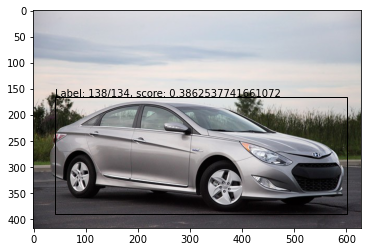

In [14]:
eval_and_plot_image(model_tot, dataset_tot, 25, True)

In [ ]:
import xml.dom.minidom
def get_BB_xml(path):
    document = xml.dom.minidom.parse(path)
    x1 = document.getElementsByTagName("xmin")[0]
    x1=x1.childNodes[0]
    x1=x1.nodeValue
    y1 = document.getElementsByTagName("ymin")[0]
    y1=y1.childNodes[0]
    y1=y1.nodeValue
    x2 = document.getElementsByTagName("xmax")[0]
    x2=x2.childNodes[0]
    x2=x2.nodeValue
    y2 = document.getElementsByTagName("ymax")[0]
    y2=y2.childNodes[0]
    y2=y2.nodeValue
    return torch.tensor([float(x1),float(y1),float(x2),float(y2)],dtype=torch.float32)
bbox=[]
for i in range(433):
    bbox.append(get_BB_xml("LPtrain/annotations/Cars{}.xml".format(i)))
with open('lp_bb.txt', 'w') as f:
    for item in bbox:
        f.write("{}\t{}\t{}\t{}\n".format(item[0],item[1],item[2],item[3]))



In [21]:

def score_model(model, df, indx):
    model = model.eval()
    image, target = df[indx]
    images = torch.stack([image]+[image]).to(device)
    with torch.no_grad():
        out=model(images)
        keep = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], 0.1)
        for indx in keep:
            if(target['labels'][0].to(device) == out[0]['labels'][indx]) or out[0]['labels'][indx] == 197:
                return 1
            else:
                return 0
score=0           
for i in range(8576):   
    score+=score_model(model_tot,dataset_tot,i)
print(score)

5471
